In [ ]:
from google.colab import drive
drive.mount('/gdrive')

!pip install torchview
!pip install timm huggingface_hub

# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from sklearn.preprocessing import LabelEncoder

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

f1_average = 'macro'

from huggingface_hub import login
# Personal token needed to download the weights of the model after authorization.
# Check https://huggingface.co/MahmoodLab/UNI
login(token="")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cuda


# Parameters

In [ ]:
# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 100

# Regularisation
DROPOUT_RATE = 0.5
L1_LAMBDA = 0
L2_LAMBDA = 1e-3

BATCH_SIZE = 32

UNFREEZE_LAST = 0
FINETUNE_STEPS = 1

USE_MASKS = False
TRAIN_FIRST_LAYER = False
MASK_FR = 0
MASK_MINV = 0.0
af = MASK_FR > 0.0
DATASET_PATH = "/dataset/clean_mask_patch_cropped/"
DRIVE_ROOT = "/gdrive/My Drive/ANN-2ndChallenge/"


# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

ms ="MASKS" if USE_MASKS else "NOMASKS"
t1 ="TR1" if TRAIN_FIRST_LAYER else ""
experiment_name = f"UNI_LINEAR_masotiles_patch_nocut_FNT{FINETUNE_STEPS}_UNFR{UNFREEZE_LAST}_{ms}_{t1}_MFR{MASK_FR}_MMV{MASK_MINV}_LR{LEARNING_RATE}_EPOCHS{EPOCHS}_PAT{PATIENCE}_DROP{DROPOUT_RATE}_L1{L1_LAMBDA}_L2{L2_LAMBDA}_BS{BATCH_SIZE}"
print(f"Experiment name {experiment_name}")

Epochs: 1000
Batch Size: 32
Learning Rate: 0.001
Dropout Rate: 0.5
L1 Penalty: 0
L2 Penalty: 0.001
Experiment name UNI_LINEAR_masotiles_patch_nocut_FNT1_UNFR0_NOMASKS__MFR0_MMV0.0_LR0.001_EPOCHS1000_PAT100_DROP0.5_L10_L20.001_BS32


# Dataset Loading

In [ ]:
# Dataset loaded as a zip and the extracted on the remote machine. This was done to avoide the drive-to-colab data transfer bottleneck
drive_zip_path = "/gdrive/My Drive/ANN-2ndChallenge/dataset/clean_aug_patches.zip"
local_zip_path = "/content/temp_extract_folder.zip"
local_extract_path = "/content/dataset_unzipped/"

if not os.path.exists(local_extract_path):
    shutil.copy(drive_zip_path, local_zip_path)
    shutil.unpack_archive(local_zip_path, local_extract_path)
    print("Extraction Complete!")
else:
    print("Dataset already present locally.")

if "clean_aug_patches" in os.listdir(local_extract_path):
    BASE_PATH = os.path.join(local_extract_path, "clean_aug_patches/")
else:
    BASE_PATH = os.path.join(local_extract_path, "")

TRAIN_LABELS_PATH = BASE_PATH + "train_labels.csv"
TRAIN_IMAGES_PATH = BASE_PATH + "train_data"
TRAIN_MASKS_PATH  = BASE_PATH + "train_data"

# Load training labels
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)

cells_images = []
masks_images = []
ids_list = []

# Load training images and masks based on labels
for idx, row in train_labels_df.iterrows():
    img_filename = row['sample_index']

    img_path = os.path.join(TRAIN_IMAGES_PATH, img_filename)
    mask_filename = img_filename.replace("img", "mask")
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_filename)
    img = cv2.imread(img_path)
    if img.shape != (224, 224, 3):
        print(img_filename)
        print(img.shape)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is not None and mask is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        img = img / 255.0  # Normalize pixel values to [0, 1]
        mask = mask / 255.0  # Normalize mask values to [0, 1]

        cells_images.append(img)
        masks_images.append(mask)
        ids_list.append(img_filename)
    else:
        print(f"Warning: Could not load image or mask for {img_filename}")
        print(f"Image path: '{img_path}'")
        print(f"Mask path: '{mask_path}'")

# Convert lists to numpy arrays
cells = np.array(cells_images)
masks = np.array(masks_images)

print(f"Loaded {len(cells)} cell images and {len(masks)} masks.")

Extraction Complete!
Loaded 2785 cell images and 2785 masks.


# Validation Split Creation

In [ ]:
# Import of libraries for removing unused variables from the RAM
import gc
import re
import numpy as np
import random
from sklearn.model_selection import GroupShuffleSplit

X_rgb = np.array(cells_images, dtype=np.float32)
del cells_images
gc.collect()

X_masks = np.array(masks_images, dtype=np.float32)
del masks_images
gc.collect()

ids = np.array(ids_list)
del ids_list

if X_masks.ndim == 3:
    X_masks = np.expand_dims(X_masks, axis=-1)

if USE_MASKS or MASK_FR > 0.0:
    X = np.concatenate((X_rgb, X_masks), axis=-1)
    del X_rgb
    del X_masks
    gc.collect()
else:
    X = X_rgb
    del X_rgb
    del X_masks
    gc.collect()

y = train_labels_df['label'].values
y = y.reshape(-1, 1) if y.ndim == 1 else y

VAL_SPLIT = 0.2

# Function that allows to extract the id of the image associated to different tiles
def get_patient_id(filename):
    match = re.search(r'\d+', str(filename))
    if match:
        return match.group()
    return filename

patient_groups = np.array([get_patient_id(filename) for filename in ids])

# Stratified GroupShuffleSplit: split by patient groups while maintaining class balance
y_flat = y.flatten()
unique_patients = np.unique(patient_groups)
train_idxs = []
val_idxs = []

for label in np.unique(y_flat):
    label_mask = y_flat == label
    label_patients = unique_patients[np.isin(unique_patients,
                                             patient_groups[label_mask])]

    # Shuffle patients with this label
    rng = np.random.RandomState(SEED)
    shuffled_patients = rng.permutation(label_patients)

    # Split patients for this class
    split_point = int(len(shuffled_patients) * (1 - VAL_SPLIT))
    train_patients = shuffled_patients[:split_point]
    val_patients = shuffled_patients[split_point:]

    # Get all images for these patients
    train_idxs.extend(np.where(np.isin(patient_groups, train_patients))[0])
    val_idxs.extend(np.where(np.isin(patient_groups, val_patients))[0])

train_idxs = np.array(train_idxs)
val_idxs = np.array(val_idxs)

X_val = X[val_idxs]
y_val = y[val_idxs]
ids_val = ids[val_idxs]

X_train = X[train_idxs]
y_train = y[train_idxs]
ids_train = ids[train_idxs]

del X
del y
del ids
gc.collect()

train_groups = set([get_patient_id(i) for i in ids_train])
val_groups = set([get_patient_id(i) for i in ids_val])
common_patients = train_groups.intersection(val_groups)

if len(common_patients) > 0:
    print(f"Fonded {len(common_patients)} duplicates between Train and Validation!")
    raise ValueError("DATA LEAKAGE")
else:
    print("No leakage")

sample_train_id = list(train_groups)[0]
files_in_train = [f for f in ids_train if get_patient_id(f) == sample_train_id]
files_in_val = [f for f in ids_val if get_patient_id(f) == sample_train_id]

print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")


No leakage
Training Data Shape: (2220, 224, 224, 3)
Validation Data Shape: (565, 224, 224, 3)


# Encoding

In [ ]:
# Define the number of classes
num_classes = len(np.unique(y_train))

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

print("Input Shape:", X_train.shape)
print("Number of Classes:", num_classes)

Input Shape: (2220, 224, 224, 3)
Number of Classes: 4


In [ ]:
in_channels = 4 if USE_MASKS or MASK_FR > 0.0 else 3
if X_train.shape[-1] == in_channels:
    # CASE A: Data is (N, 224, 224, 4) -> Standard OpenCV format
    print("Fixing format from (N, H, W, C) to (N, C, H, W)...")
    X_train = np.transpose(X_train, (0, 3, 1, 2))
    X_val   = np.transpose(X_val,   (0, 3, 1, 2))

elif X_train.shape[1] == 224 and X_train.shape[2] == in_channels:
    # CASE B: Data is (N, 224, 4, 224) -> The weird shape causing your error
    print("Fixing weird format from (N, H, C, W) to (N, C, H, W)...")
    X_train = np.transpose(X_train, (0, 2, 1, 3))
    X_val   = np.transpose(X_val,   (0, 2, 1, 3))

print(f"Fixed X_train shape: {X_train.shape}")

Fixing format from (N, H, W, C) to (N, C, H, W)...
Fixed X_train shape: (2220, 3, 224, 224)


# Augmentation

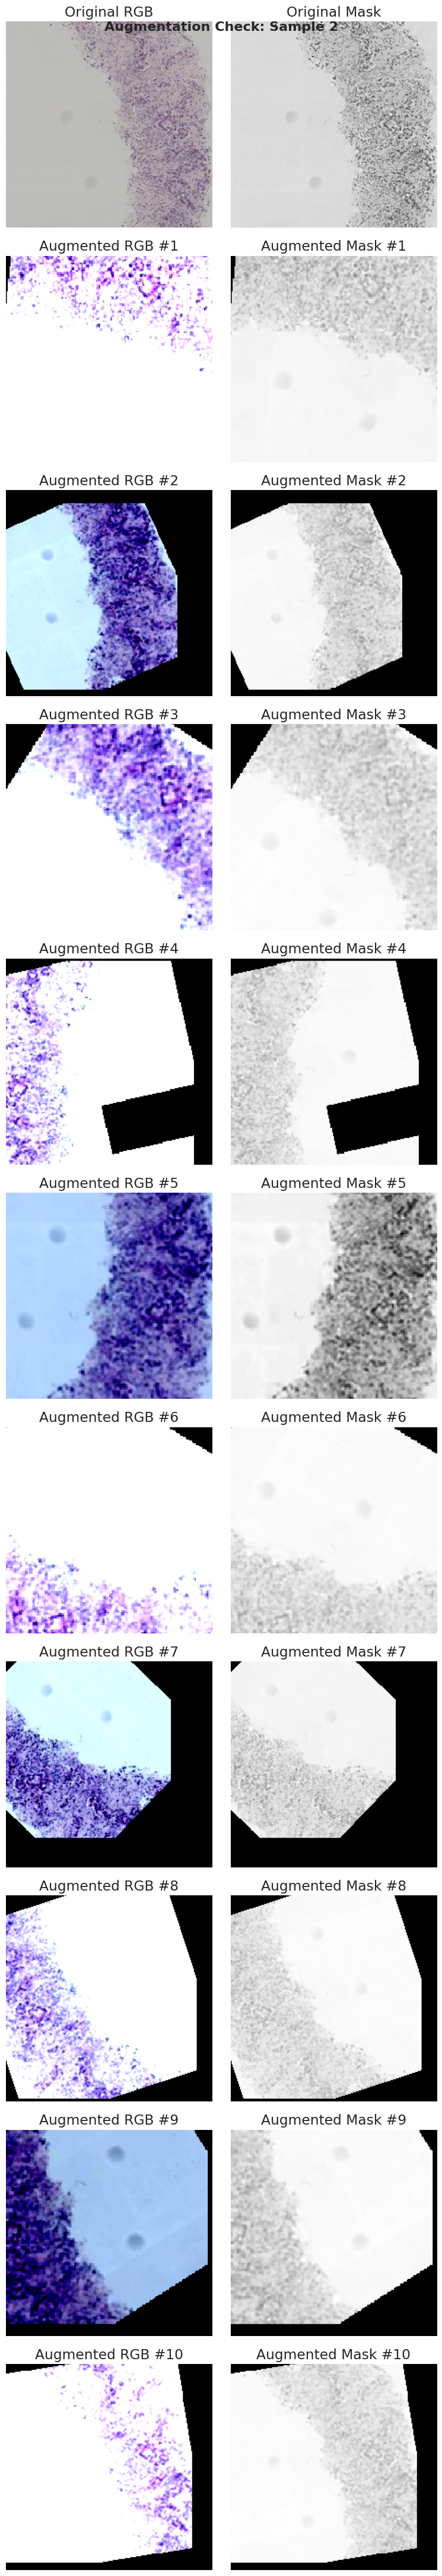

In [ ]:
from torchvision.transforms import v2
import cv2

def visualize_augmentations(dataset, sample_idx, num_variations=3):
    """
    Visualizes the original image vs. multiple augmented versions from the dataset.

    Args:
        dataset: Your instantiated AugmentedDataset.
        sample_idx: The integer index of the image to visualize.
        num_variations: How many random augmented versions to show.
    """

    # 1. GET ORIGINAL (RAW) DATA
    # We access .x_data directly to bypass the __getitem__ transforms
    raw_data = dataset.x_data[sample_idx] # Shape: (4, 224, 224)

    # Prepare Original for plotting
    # Transpose (C, H, W) -> (H, W, C)
    raw_display = np.transpose(raw_data, (1, 2, 0))
    raw_rgb = raw_display[:, :, :3]
    raw_mask = raw_display[:, :, -1]

    # 2. SETUP PLOT
    # Rows = 1 (Original) + num_variations
    # Cols = 2 (RGB + Mask)
    fig, axes = plt.subplots(1 + num_variations, 2, figsize=(8, 4 * (1 + num_variations)))
    plt.suptitle(f"Augmentation Check: Sample {sample_idx}", fontsize=16, fontweight='bold')

    # 3. PLOT ORIGINAL
    axes[0, 0].imshow(np.clip(raw_rgb, 0, 1))
    axes[0, 0].set_title("Original RGB")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(raw_mask, cmap='gray')
    axes[0, 1].set_title("Original Mask")
    axes[0, 1].axis('off')

    # 4. PLOT AUGMENTED VERSIONS
    for i in range(num_variations):
        # Call __getitem__ to trigger the random transforms
        aug_tensor, label = dataset[sample_idx]

        # Convert Tensor -> Numpy
        aug_np = aug_tensor.numpy()

        # Transpose (C, H, W) -> (H, W, C)
        aug_display = np.transpose(aug_np, (1, 2, 0))

        # Split Channels
        aug_rgb = aug_display[:, :, :3]
        aug_mask = aug_display[:, :, -1]

        # Plot RGB (Clip values to 0-1 range in case ColorJitter went out of bounds)
        row = i + 1
        axes[row, 0].imshow(np.clip(aug_rgb, 0, 1))
        axes[row, 0].set_title(f"Augmented RGB #{i+1}")
        axes[row, 0].axis('off')

        # Plot Mask
        axes[row, 1].imshow(aug_mask, cmap='gray')
        axes[row, 1].set_title(f"Augmented Mask #{i+1}")
        axes[row, 1].axis('off')

    plt.tight_layout()
    plt.show()

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


class AugmentedDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for pre-transposed (Channel-First) data.
    Input shape expectation: (N, 4, 224, 224)
    """
    def __init__(self, x_data, y_data,
                 geo_transform=None,
                 col_transform=None,
                 normalize_imagenet=False,
                 final_noise_m=0.0,
                 final_noise_std=0.0,
                 apply_focus=False,
                 focus_radius=50.0,
                 focus_min_vis=0.0,
                 focus_type='linear'):

        self.x_data = x_data
        self.y_data = y_data
        self.geo_transform = geo_transform # Spatial augmentations
        self.col_transform = col_transform # Color-based augmentations
        self.final_noise_m = final_noise_m # Mean of Gaussian noise added at the end
        self.final_noise_std = final_noise_std # Standard deviation of Gaussian noise
        self.apply_focus = apply_focus # Whether to apply mask-based spatial weighting
        self.focus_radius = focus_radius # Radius controlling mask fade-out strength
        self.focus_min_vis = focus_min_vis # Minimum visibility outside the mask
        self.focus_type = focus_type # Decay type for focus mask ('linear' or 'exponential')

        if normalize_imagenet:
            # ImageNet statistics
            self.normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        else:
            self.normalize = None

    def __len__(self):
        return len(self.x_data)

    def _compute_focus_mask(self, mask_tensor):
        """
        Internal helper to compute the fade weights using OpenCV.
        mask_tensor: 2D Tensor (H, W)
        Returns: 2D Tensor (H, W) with values 0.0 to 1.0
        """
        # 1. Convert to Numpy uint8 for OpenCV
        # We ensure values are scaled to 0-255 so thresholding works
        mask_np = mask_tensor.detach().cpu().numpy()

        # Handle cases where mask is 0.0-1.0 or 0-255
        if mask_np.max() <= 1.0:
            mask_np = (mask_np * 255).astype(np.uint8)
        else:
            mask_np = mask_np.astype(np.uint8)

        # 2. Binary Threshold & Invert
        _, binary_mask = cv2.threshold(mask_np, 127, 255, cv2.THRESH_BINARY)
        inv_mask = cv2.bitwise_not(binary_mask)

        # 3. Distance Transform
        dist = cv2.distanceTransform(inv_mask, cv2.DIST_L2, 5)

        # 4. Calculate Weights
        if self.focus_type == 'exponential':
            weights = np.exp(-dist / self.focus_radius)
        else:
            # Linear decay: 1 - (dist / radius)
            weights = 1.0 - (dist / self.focus_radius)

        # 5. Clip and Clean
        weights = np.maximum(weights, self.focus_min_vis)
        weights = np.minimum(weights, 1.0)

        # 6. Convert back to Tensor
        return torch.from_numpy(weights).float()

    def __getitem__(self, idx):
        # 1. Get the image (Shape: 4, 224, 224)
        img_np = self.x_data[idx]
        label = self.y_data[idx]

        # 2. Convert to Tensor
        img_tensor = torch.from_numpy(img_np).float()

        # 3. Apply Color Transforms (to RGB only)
        if self.col_transform:
            rgb = img_tensor[:3, :, :]
            mask = img_tensor[3:, :, :]
            rgb = self.col_transform(rgb)
            img_tensor = torch.cat([rgb, mask], dim=0)

        # 4. Apply Geometric Transforms (Rotations, Flips, etc.)
        if self.geo_transform:
            img_tensor = self.geo_transform(img_tensor)

        if self.apply_focus:
            # Extract Mask channel (index 3)
            current_mask = img_tensor[3, :, :]

            # Compute weight map (H, W)
            weights = self._compute_focus_mask(current_mask)

            # Apply weights to RGB channels only
            img_tensor[:3, :, :] = img_tensor[:3, :, :] * weights

        # 6. Apply Noise
        if self.final_noise_std > 0:
            noise = v2.GaussianNoise(mean=self.final_noise_m, sigma=self.final_noise_std)
            rgb = img_tensor[:3, :, :]
            mask = img_tensor[3:, :, :] # Keep mask clean
            rgb = noise(rgb)
            img_tensor = torch.cat([rgb, mask], dim=0)

        # 7. Normalize (ImageNet statistics)
        if self.normalize:
            rgb = img_tensor[:3, :, :]
            mask = img_tensor[3:, :, :]
            rgb = self.normalize(rgb)
            img_tensor = torch.cat([rgb, mask], dim=0)

        if not USE_MASKS:
            img_tensor = img_tensor[:3, :, :]

        return img_tensor, torch.tensor(label, dtype=torch.long)

class AddGaussianNoise(object):
    def __init__(self, min_std=0.01255, max_std=0.05255):
        self.min_std = min_std
        self.max_std = max_std

    def __call__(self, tensor):
        # Generate a random standard deviation (scale) between the min and max for this image
        std = (self.max_std - self.min_std) * torch.rand(1) + self.min_std
        return tensor + torch.randn(tensor.size()) * std

    def __repr__(self):
        return self.__class__.__name__ + f'(min_std={self.min_std}, max_std={self.max_std})'

train_col_transforms = v2.Compose([
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

fill_col = 0.0
fill = (fill_col, fill_col, fill_col)

train_geo_transforms = v2.Compose([
    v2.RandomErasing(p=0.20, scale=(0.01, 0.1), ratio=(1/3.0, 1/1.5), value=0.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 90), expand=False, fill=fill),
    v2.RandomAffine(degrees=(0, 0), scale=(0.9, 1.5), fill=fill_col, translate=(0.2, 0.2)),
])

train_aug_ds = AugmentedDataset(X_train, y_train, geo_transform=train_geo_transforms, col_transform=train_col_transforms, normalize_imagenet=True, final_noise_m=0.0, final_noise_std=0.0, focus_min_vis=MASK_MINV, focus_radius=MASK_FR, focus_type='linear', apply_focus=af)
val_aug_ds   = AugmentedDataset(X_val, y_val, geo_transform=None, col_transform=None, normalize_imagenet=True, focus_min_vis=MASK_MINV, focus_radius=MASK_FR, focus_type='linear', apply_focus=af)


# Pick an index and show 3 different random augmentations of it
visualize_augmentations(train_aug_ds, sample_idx=2, num_variations=10)

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_aug_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_aug_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


# Model class

In [ ]:
import timm

class UniTransferLearning(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, freeze_backbone=True):
        super().__init__()

        print("Loading UNI (ViT-Large) from Hugging Face...")
        # Load the pretrained UNI backbone
        self.backbone = timm.create_model(
            "hf-hub:MahmoodLab/uni",
            pretrained=True,
            init_values=1e-5,
            dynamic_img_size=True,
            num_classes=0 # Returns features (1024 dim) instead of logits
        )

        if freeze_backbone:
            print("Freezing Backbone...")
            for param in self.backbone.parameters():
                param.requires_grad = False

        # UNI output dimension is 1024
        embedding_dim = 1024

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.BatchNorm1d(512), # Batch Norm stabilizes ViT features
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

# Train functions

In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    running_grad_norm = 0.0
    all_predictions = []
    all_targets = []
    optimizer.zero_grad(set_to_none=True)

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        running_grad_norm += grad_norm.item()


        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average=f1_average
    )

    avg_grad_norm = running_grad_norm / len(train_loader)

    return epoch_loss, epoch_f1, avg_grad_norm

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            # with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            #     logits = model(inputs)
            #     loss = criterion(logits, targets)
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average=f1_average
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, grad_norm, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)
    writer.add_scalar('GradNorm/Training', grad_norm, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': [],
        'grad_norm': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1, grad_norm = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)
        training_history['grad_norm'].append(grad_norm)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, grad_norm, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | GradNorm={grad_norm:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), DRIVE_ROOT + "models/maso_models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(DRIVE_ROOT + "models/maso_models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), DRIVE_ROOT + "models/maso_models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

# Train

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim

# UNI requires 3 channels (RGB) and 224x224 resolution
input_shape = (3, 224, 224)

# Instantiate UNI model and move to computing device (CPU/GPU)
model = UniTransferLearning(
    num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=True
).to(device)

# Display model architecture summary
try:
    summary(model, input_size=input_shape)
except Exception as e:
    print("Torchsummary skipped (common with ViT models), model loaded successfully.")

# Set up TensorBoard logging and save model architecture
x = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Calculate Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)
weights_tensor = weights_tensor.to(device)
print(f"Class Weights used: {weights_tensor}")

# Loss Function with Class Weights
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

Loading UNI (ViT-Large) from Hugging Face...


config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Freezing Backbone...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1024, 14, 14]         787,456
          Identity-2         [-1, 14, 14, 1024]               0
        PatchEmbed-3         [-1, 14, 14, 1024]               0
           Dropout-4            [-1, 197, 1024]               0
          Identity-5            [-1, 197, 1024]               0
          Identity-6            [-1, 197, 1024]               0
         LayerNorm-7            [-1, 197, 1024]           2,048
            Linear-8            [-1, 197, 3072]       3,148,800
          Identity-9          [-1, 16, 197, 64]               0
         Identity-10          [-1, 16, 197, 64]               0
         Identity-11            [-1, 197, 1024]               0
           Linear-12            [-1, 197, 1024]       1,049,600
          Dropout-13            [-1, 197, 1024]               0
        Attention-

In [ ]:
import copy
import torch.optim as optim

def train_finetune_uni(steps, model):
    models = []
    performances = []
    best_model = None
    best_performance = 0.0

    # Determine total blocks in UNI
    total_blocks = len(model.backbone.blocks)

    for i in range(steps):
        print(f"\n=== Fine-tuning Step {i} ===")

        # Tensorboard setup
        logs_dir = "logs"
        writer = SummaryWriter("./"+logs_dir+"/"+experiment_name+str(i))
        try:
            writer.add_graph(model, x)
        except:
            pass

        # Handle Best Model Logic
        if best_model is not None:
            print("Restoring best model from previous step...")
            model = copy.deepcopy(best_model)

        # Unfreezing Logic
        if i == 0:
            print("Mode: Training Classifier Head Only (Backbone Frozen)")
            # Ensure backbone is frozen
            for param in model.backbone.parameters():
                param.requires_grad = False
            # Ensure classifier is trainable
            for param in model.classifier.parameters():
                param.requires_grad = True

            # Use standard Learning Rate for the Head
            current_lr = LEARNING_RATE

        else:
            # Unfreeze the last 'i' blocks
            # e.g., if i=1, unfreeze the very last block.
            # if i=2, unfreeze the last 2 blocks.
            blocks_to_unfreeze = model.backbone.blocks[-i:]

            print(f"Mode: Unfreezing last {i} Transformer Blocks out of {total_blocks}")

            # Always unfreeze the final Norm layer in ViTs when unfreezing backbone
            if hasattr(model.backbone, 'norm'):
                for param in model.backbone.norm.parameters():
                    param.requires_grad = True

            for block in blocks_to_unfreeze:
                for param in block.parameters():
                    param.requires_grad = True

            # Lower Learning Rate for Fine-Tuning
            current_lr = 1e-5
            print(f"Lowering Learning Rate to {current_lr} for fine-tuning")

        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(trainable_params, lr=current_lr, weight_decay=1e-4)

        # 5. Run Training
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            writer=writer,
            verbose=1,
            experiment_name=experiment_name+str(i),
            patience=PATIENCE,
            l1_lambda=L1_LAMBDA,
            l2_lambda=L2_LAMBDA
        )

        # 6. Save Best Result
        f1 = max(history['val_f1'])
        if f1 > best_performance:
            print(f"New best model found! F1: {f1:.4f} > {best_performance:.4f}")
            best_model = copy.deepcopy(model)
            best_performance = f1
        else:
            print(f"No improvement this step. Best remains: {best_performance:.4f}")

        models.append(copy.deepcopy(model))
        performances.append(f1)

        final_val_f1 = round(f1 * 100, 2)
        print(f'Step {i} finished. Validation F1: {final_val_f1}%')

    return (best_model, models, performances)

In [ ]:
best_model, models, performances = train_finetune_uni(FINETUNE_STEPS, model)
print(performances)


=== Fine-tuning Step 0 ===
Mode: Training Classifier Head Only (Backbone Frozen)
Training 1000 epochs...
Epoch   1/1000 | Train: Loss=528.8394, F1 Score=0.4009 | GradNorm=4.4975 | Val: Loss=1.4413, F1 Score=0.3376
Epoch   2/1000 | Train: Loss=528.5886, F1 Score=0.5171 | GradNorm=3.6485 | Val: Loss=1.4179, F1 Score=0.3171
Epoch   3/1000 | Train: Loss=528.4056, F1 Score=0.5951 | GradNorm=3.2170 | Val: Loss=1.5802, F1 Score=0.3182
Epoch   4/1000 | Train: Loss=528.3583, F1 Score=0.6219 | GradNorm=3.1837 | Val: Loss=1.4382, F1 Score=0.3880
Epoch   5/1000 | Train: Loss=528.2423, F1 Score=0.6655 | GradNorm=2.8314 | Val: Loss=1.4479, F1 Score=0.3986
Epoch   6/1000 | Train: Loss=528.2029, F1 Score=0.6748 | GradNorm=2.8096 | Val: Loss=1.4067, F1 Score=0.4331
Epoch   7/1000 | Train: Loss=528.1620, F1 Score=0.6865 | GradNorm=2.6888 | Val: Loss=1.5956, F1 Score=0.3924
Epoch   8/1000 | Train: Loss=528.1116, F1 Score=0.7073 | GradNorm=2.6296 | Val: Loss=1.4716, F1 Score=0.3617
Epoch   9/1000 | Train

# Confusion Matrix

Accuracy:  0.4283
Precision: 0.4443
Recall:    0.4335
F1 Score:  0.4331


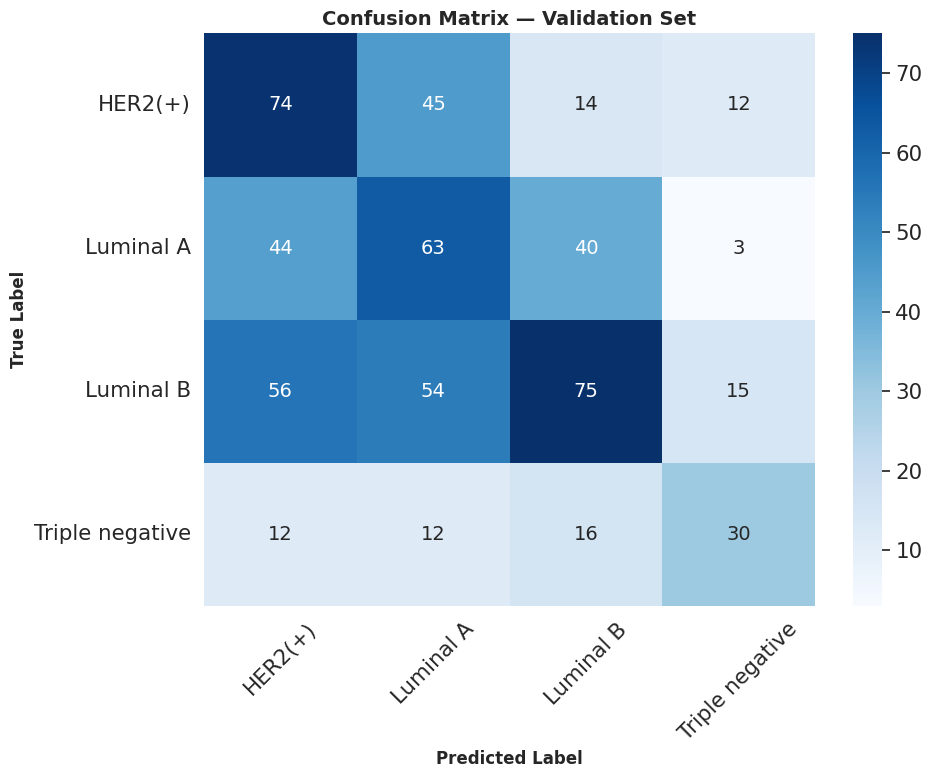

In [ ]:
val_preds, val_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# CALCULATE METRICS
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average=f1_average)
val_rec = recall_score(val_targets, val_preds, average=f1_average)
val_f1 = f1_score(val_targets, val_preds, average=f1_average)

print(f"Accuracy:  {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(f"F1 Score:  {val_f1:.4f}")

# 3. CONFUSION MATRIX
cm = confusion_matrix(val_targets, val_preds)

plt.figure(figsize=(10, 8))

# FIX B: Use le.classes_ to show String Labels on the axes
sns.heatmap(
    cm,
    annot=True,      # Show numbers inside boxes
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix — Validation Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Test

Loading test data from /content/dataset_unzipped/clean_aug_patches/test_data...
Processed Test Data Shape: (477, 4, 224, 224)
Final Tensor Shape for UNI: torch.Size([477, 3, 224, 224])
Running inference...
Submission saved to /gdrive/My Drive/ANN-2ndChallenge/submissions/maso_submissions/UNI_LINEAR_masotiles_patch_nocut_FNT1_UNFR0_NOMASKS__MFR0_MMV0.0_LR0.001_EPOCHS1000_PAT100_DROP0.5_L10_L20.001_BS32.csv
   sample_index            label
0  img_0378.png        Luminal B
1  img_0188.png          HER2(+)
2  img_0301.png        Luminal B
3  img_0443.png  Triple negative
4  img_0447.png        Luminal B


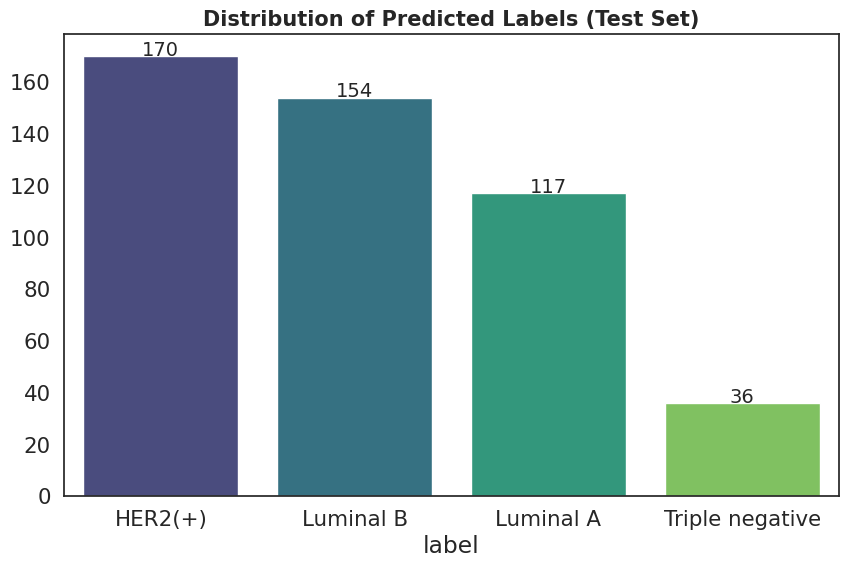

In [ ]:
# --- LOAD TEST DATA ---

TEST_IMAGES_PATH = BASE_PATH + "test_data"
TEST_MASKS_PATH  = BASE_PATH + "test_data"

test_imgs = []
test_masks = []
test_ids = []

if not os.path.exists(TEST_IMAGES_PATH):
    print(f"ERROR: Path {TEST_IMAGES_PATH} does not exist. Check your folder structure.")
else:
    print(f"Loading test data from {TEST_IMAGES_PATH}...")
    for img_filename in os.listdir(TEST_IMAGES_PATH):
        # Filter for images only (skip masks if they are in the same folder)
        if "mask" in img_filename:
            continue

        mask_filename = img_filename.replace("img", "mask")

        img_path = os.path.join(TEST_IMAGES_PATH, img_filename)
        mask_path = os.path.join(TEST_MASKS_PATH, mask_filename)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is not None and mask is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            mask = mask / 255.0

            test_imgs.append(img)
            test_masks.append(mask)
            test_ids.append(img_filename)

    X_rgb = np.array(test_imgs)
    X_masks = np.array(test_masks)
    ids = np.array(test_ids)

    # Add channel dim to masks
    if X_masks.ndim == 3:
        X_masks = np.expand_dims(X_masks, axis=-1)

    # Concatenate temporarily for processing
    X = np.concatenate((X_rgb, X_masks), axis=-1)

    # Fix Shapes (N, H, W, C) -> (N, C, H, W)
    if X.shape[-1] == 4:
        X = np.transpose(X, (0, 3, 1, 2))
    elif X.shape[1] == 224 and X.shape[2] == 4:
        X = np.transpose(X, (0, 2, 1, 3))

    print(f"Processed Test Data Shape: {X.shape}")

    # --- PREPARE TENSOR ---
    test_tensor = torch.from_numpy(X).float()

    # Apply Focus Mask (Using logic from your dataset)
    if MASK_FR > 0.0:
        # We reuse the function from your validation dataset instance
        print("Applying focus mask to test set...")
        # Iterate manually or batch process (iterating is safer for memory)
        for i in range(len(test_tensor)):
            weights = val_aug_ds._compute_focus_mask(test_tensor[i, 3, :, :])
            test_tensor[i, :3, :, :] = test_tensor[i, :3, :, :] * weights

    # Normalize RGB
    normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    test_tensor[:, :3, :, :] = normalize(test_tensor[:, :3, :, :])

    test_tensor = test_tensor[:, :3, :, :]
    print(f"Final Tensor Shape for UNI: {test_tensor.shape}")

    # Create DataLoader
    test_ds = TensorDataset(test_tensor)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    # --- RUN INFERENCE ---
    print("Running inference...")
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            logits = model(inputs)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)

    # --- SAVE CSV ---
    predicted_labels = le.inverse_transform(all_preds)

    submission_df = pd.DataFrame({
        'sample_index': ids,
        'label': predicted_labels
    })

    # Ensure directory exists
    os.makedirs(DRIVE_ROOT + "submissions/maso_submissions/", exist_ok=True)
    csv_filename = DRIVE_ROOT + "submissions/maso_submissions/" + experiment_name + ".csv"
    submission_df.to_csv(csv_filename, index=False)

    print(f"Submission saved to {csv_filename}")
    print(submission_df.head())

    # Plot inference results
    plt.figure(figsize=(10, 6))
    label_counts = submission_df['label'].value_counts()
    ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('Distribution of Predicted Labels (Test Set)', fontsize=15, fontweight='bold')
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{int(height)}', ha="center")
    plt.show()